# Семинар 7: Parameter-Efficient Fine-tuning

В этом семинаре мы попробуем дообучить модель GPT2-small на задачу анализа тональности с помощью различных методов PEFT:
1. LoRa – Low-Rank Adaptation
1. Prompt tuning
1. PEFT + LP-FT

## Датасет

Для оценки качества дообучения мы будем использовать один из датасетов бенчмарка GLUE, [SST2](https://huggingface.co/datasets/sst2) (Stanford Sentiment Treebank). Датасет содержит 67 тысяч предложений с отзывами на фильмы, которые требуется классифицировать на положительные и отрицательные.

In [1]:
import torch
from torch import nn
import subprocess
import os

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "sst2", split='train[:50000]')
valid_dataset = load_dataset("glue", "sst2", split="validation")

In [3]:
train_dataset[0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

In [4]:
train_dataset[2]

{'sentence': 'that loves its characters and communicates something rather beautiful about human nature ',
 'label': 1,
 'idx': 2}

In [5]:
len(train_dataset), len(valid_dataset) 

(50000, 872)

### Инициализация токенизатора и модели

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [7]:
model_checkpoint = "gpt2"

In [8]:
# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [9]:
class Model(nn.Module):
    def __init__(self, tokenizer, num_classes=2):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_classes)
        self.model.resize_token_embeddings(len(tokenizer))
        self.config = self.model.config

    def forward(self, input_ids=None, attention_mask=None, inputs_embeds=None, *args, **kwargs):
        out = self.model.transformer(
            input_ids=input_ids, inputs_embeds=inputs_embeds, attention_mask=attention_mask
        ).last_hidden_state
        lens = attention_mask.sum(-1).cpu() - 1
        out = out[torch.arange(len(lens)), lens.to(torch.long)]
        return self.model.score(out)
    
    @property
    def device(self):
        return next(self.model.parameters()).device


num_classes = 2
model = Model(tokenizer, num_classes)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [10]:
model

Model(
  (model): GPT2ForSequenceClassification(
    (transformer): GPT2Model(
      (wte): Embedding(50258, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2SdpaAttention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (score): Linear(in_features=768, out

In [11]:
sum(p.numel() for p in model.parameters())

124442112

### Проверка токенизатора

In [12]:
# Running tokenizer on sample data
tokenizer(train_dataset[0]["sentence"])

{'input_ids': [24717, 649, 3200, 507, 422, 262, 21694, 4991, 220], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [13]:
from torch.utils.data import DataLoader

In [14]:
batch_size = 128

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=8)
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, num_workers=8)

In [15]:
import numpy as np

# Percentage of classes in dataset

print("       0       1")
classes = [t["label"] for t in train_dataset]
print(f"Train: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

classes = [t["label"] for t in valid_dataset]
print(f"Valid: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

       0       1
Train: 0.442 0.558
Valid: 0.491 0.509


### Объявление функции для обучения моделей

In [16]:
from IPython.display import clear_output
from random import sample
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics.functional import accuracy
from torch.optim import AdamW
import seaborn as sns

sns.set_theme()

In [17]:
_ = model.to(device)

In [18]:
def training_loop_fn(model, opt, total_num_iters, eval_freq, train_loader, valid_loader):
    train_loss_history, eval_loss_history = [], []
    train_acc_history, eval_acc_history = [], []
    global_step = 0

    criterion = torch.nn.CrossEntropyLoss()
    model.train()
    while True:
        for batch in tqdm(train_loader):
            tokenized = tokenizer(batch["sentence"], padding=True, return_tensors='pt')
            for k, v in tokenized.items():
                tokenized[k] = v.to(device)
            
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)
            targets = batch["label"].to(device)
            loss = criterion(logits, targets)

            opt.zero_grad()
            loss.backward()
            opt.step()

            preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]
            acc = accuracy(preds, targets, "binary")
    
            train_loss_history.append((global_step, loss.item()))
            train_acc_history.append((global_step, acc.item()))
    
            if global_step % eval_freq == 0:
                val_loss, val_acc = evaluate(model, valid_loader)
                eval_loss_history.append((global_step, val_loss))
                eval_acc_history.append((global_step, val_acc))
                                         
                model.train()

            if global_step % 250 == 0:
                clear_output(True)

                plt.figure(figsize=(15, 5))

                plt.subplot(121)
                plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                if len(eval_loss_history):
                    plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                plt.legend()    
                
                plt.subplot(122)
                plt.plot(*zip(*train_acc_history), alpha=0.5, label='train_acc')
                if len(eval_acc_history):
                    plt.plot(*zip(*eval_acc_history), color='red', label='eval_acc')
                plt.legend()
                plt.show()

            global_step += 1
            if global_step > total_num_iters:
                break
        else:
            continue
        break 


@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    loss_epoch = 0.
    num_epoch = 0.
    preds_list = []
    targets_list = []

    for eval_batch in dataloader:
        tokenized = tokenizer(eval_batch["sentence"], padding=True, return_tensors='pt')
        for k, v in tokenized.items():
            tokenized[k] = v.to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)

        loss = criterion(logits, eval_batch["label"].to(device))
        num = logits.shape[0]

        loss_epoch += loss.item() * num
        num_epoch += num
        preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]

        targets_list += eval_batch["label"].tolist()
        preds_list += preds.tolist()

    acc = accuracy(torch.tensor(preds_list).to(device), torch.tensor(targets_list).to(device), "binary")

    return loss_epoch / num_epoch, acc.item()

## Fine-tuning

Обучаем все веса модели. Данный подход будет наиболее требовательным к памяти, однако он применяется чаще всего.

In [19]:
model = Model(tokenizer, num_classes).to(device)
optimizer = AdamW(model.parameters(), lr=2e-6)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


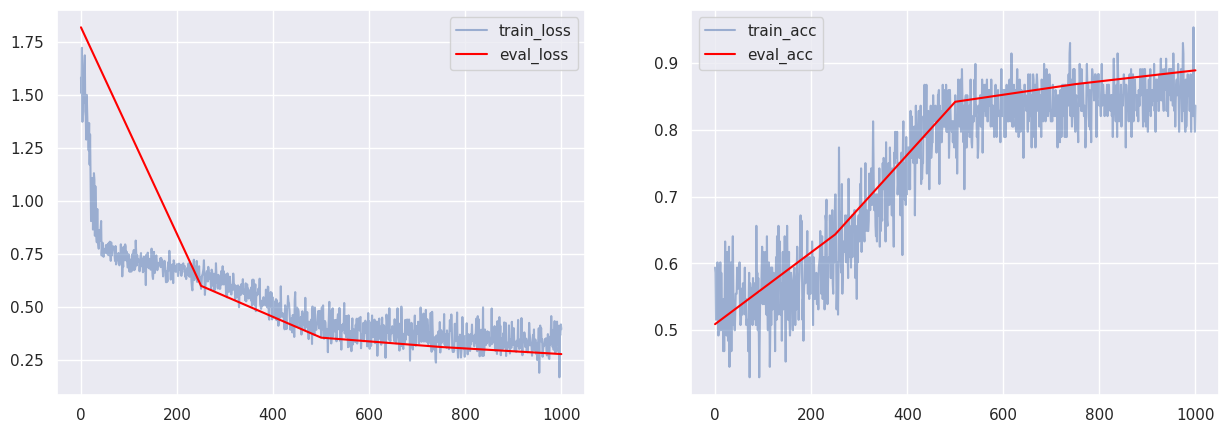

 56%|█████▌    | 218/391 [00:24<00:19,  8.99it/s]

CPU times: user 2min 40s, sys: 8.4 s, total: 2min 49s
Wall time: 2min 41s


In [20]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [21]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.27859693054759177
val accuracy: 0.8887614607810974


## Linear Probing

Учим только последний линейный слой (голову) модели.

In [54]:
del model

In [55]:
torch.cuda.empty_cache()

In [56]:
model = Model(tokenizer, num_classes).to(device)
optimizer = AdamW(model.model.score.parameters(), lr=1e-4)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


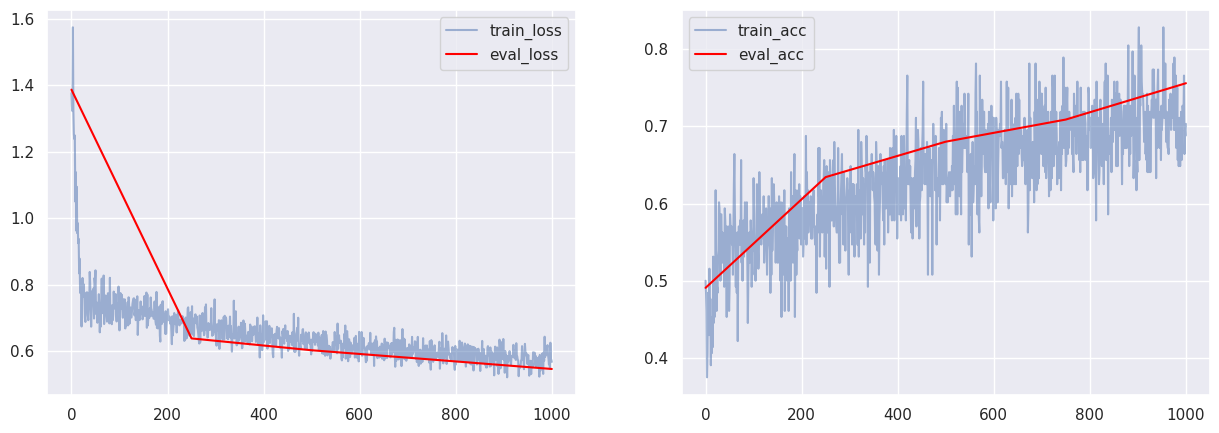

 56%|█████▌    | 218/391 [00:20<00:16, 10.45it/s]

CPU times: user 1min 35s, sys: 7.98 s, total: 1min 43s
Wall time: 1min 35s


In [57]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [58]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.5465435063073395
val accuracy: 0.7557339668273926


In [63]:
torch.save(model.model.score.state_dict(), "head.pt")

## LoRa

В оригинальной статье авторы предлагают учить только матрицы $W_K$ и $W_V$ в слоях внимания трансформера и последний линейный слой. Однако мы добавим к ним еще матрицу $W_Q$, потому что в архитектуре GPT все три матрицы считаются с помощью одного слоя, и разделять их было бы слишком неудобно.

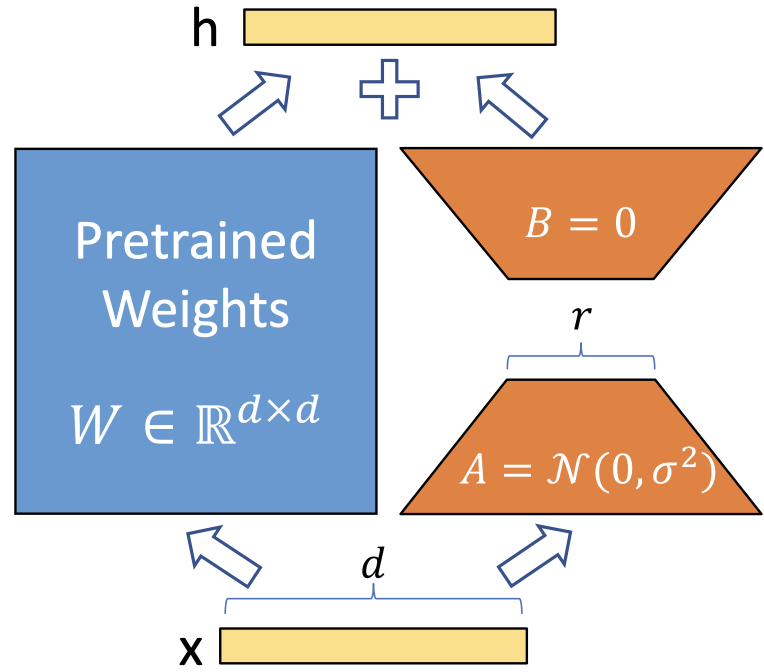

Для реализации Parameter-Efficient Fine-Tuning мы будем пользоваться библиотекой `peft` (семейство huggingface). В ней реализованы многие наиболее удачные способы дообучения моделей. Полный список можно найти [тут](https://github.com/huggingface/peft).

Самый важный параметр этой модели – ранг матриц $A$ и $B$ ($r$). Его увеличение дает больше степеней свободы в настройке добавки $AB$, повышая вместе с этим количество обучаемых параметров.

In [34]:
model

Model(
  (model): GPT2ForSequenceClassification(
    (transformer): GPT2Model(
      (wte): Embedding(50258, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2SdpaAttention(
            (c_attn): lora.Linear(
              (base_layer): Conv1D(nf=2304, nx=768)
              (lora_dropout): ModuleDict(
                (default): Dropout(p=0.1, inplace=False)
              )
              (lora_A): ModuleDict(
                (default): Linear(in_features=768, out_features=8, bias=False)
              )
              (lora_B): ModuleDict(
                (default): Linear(in_features=8, out_features=2304, bias=False)
              )
              (lora_embedding_A): ParameterDict()
              (lora_embedding_B): ParameterDict()
              (lora_magnitude_vector): ModuleDict()
            )
            (

In [19]:
from peft import get_peft_model, LoraConfig, TaskType

In [20]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=8, lora_dropout=0.1, target_modules=['c_attn']
)

model = Model(tokenizer, num_classes).to(device)
lora_model = get_peft_model(model, peft_config).to(device)
lora_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 296,448 || all params: 124,738,560 || trainable%: 0.2377


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [30]:
sum(p.numel() for p in lora_model.parameters() if p.requires_grad)

296448

In [31]:
optimizer = AdamW(lora_model.parameters(), lr=1e-4)

In [32]:
torch.cuda.empty_cache()

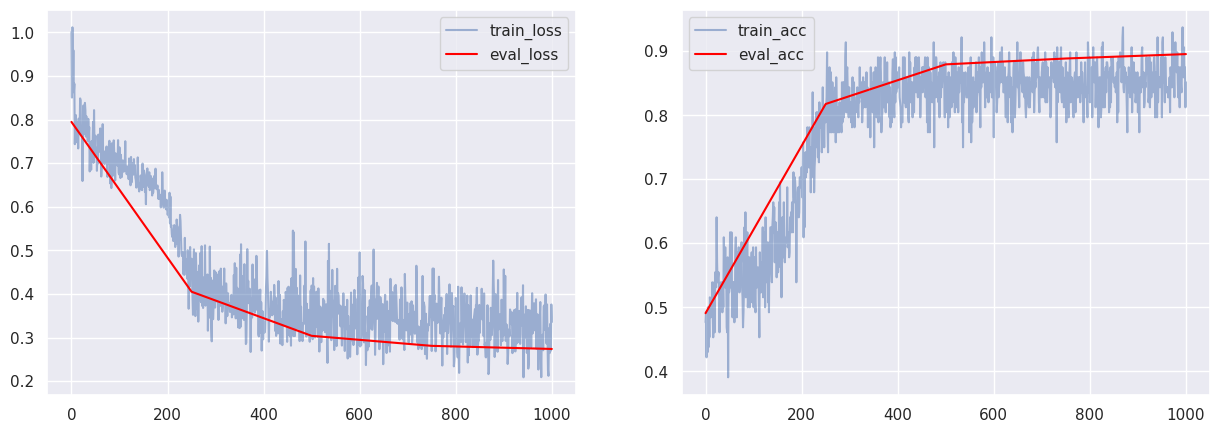

 56%|█████▌    | 218/391 [00:18<00:14, 11.78it/s]

CPU times: user 1min 28s, sys: 7.86 s, total: 1min 36s
Wall time: 1min 28s


In [33]:
%%time
training_loop_fn(lora_model, optimizer, 1000, 250, train_loader, valid_loader)

In [36]:
val_loss, val_acc = evaluate(lora_model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.2740310528956422
val accuracy: 0.8956422209739685


In [37]:
torch.save(lora_model.base_model.model.model.score.state_dict(), 'lora_head.pt')

## Prompt Tuning

Prompt Tuning – наиболее архитектурно-зависимый способ дообучения моделей, так как основан на наблюдении о том, что большие языковые модели способны решать задачи в zero-shot и few-shot парадигме (то есть опираясь только на входной промпт и текст, для которого нужно выдать ответ). Для моделей, которые могут работать в таком формате Prompt Tuning предлагает не выбирать промпт руками, а обучить его. Таким образом, этот метод лучше всего будет работать с моделями вида GPT и хуже всего с BERT. Вместе с промптом дополнительно доучивается голова.

<!-- 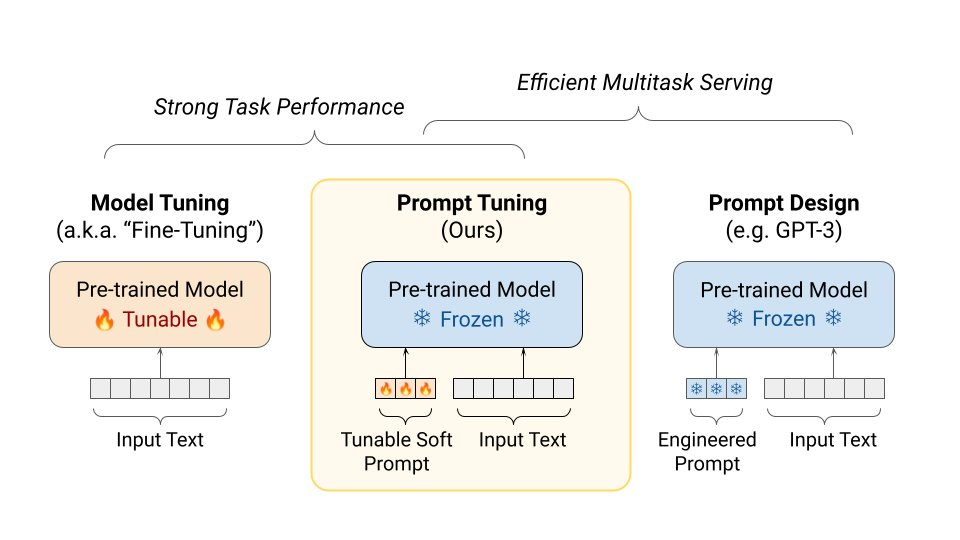 -->
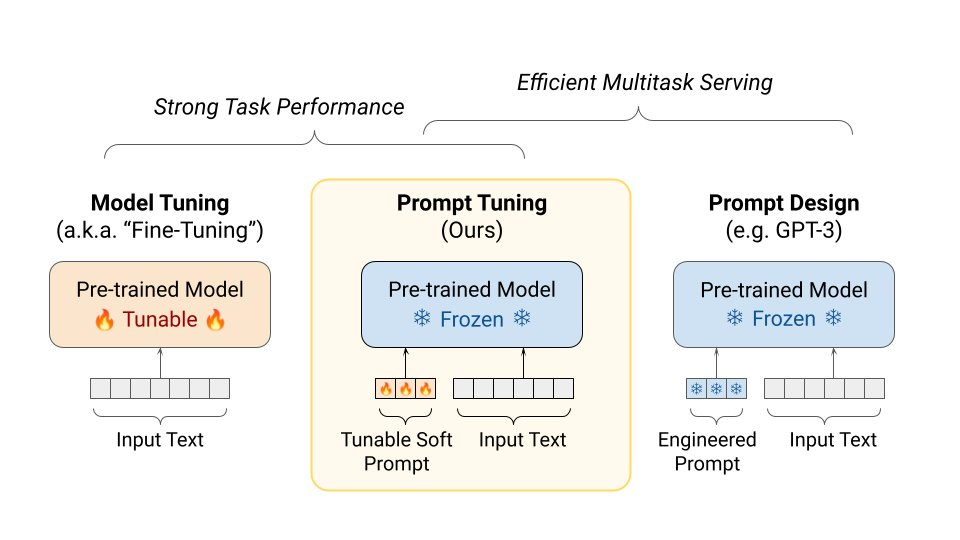


При настройке промпта можно варьировать его длину, а так же способ инициализации. Тут работает правило: чем больше датасет для дообучения, тем длинее можно брать промпты. Если датасет маленький, то длиный промпт не сможет обучиться.

In [21]:
from peft import PromptTuningConfig, PromptTuningInit

In [22]:
len(tokenizer("Predict if sentiment of this review is positive or negative")['input_ids'])

11

In [23]:
init = {PromptTuningInit.TEXT: "Predict if sentiment of this review is positive or negative"}

In [24]:
config = model.config
peft_config = PromptTuningConfig(
    prompt_tuning_init=init,
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    num_virtual_tokens=12,
    num_layers=config.n_layer,
    token_dim=config.n_embd,
    num_attention_heads=config.n_head,
)

model = Model(tokenizer, num_classes).to(device)
pt_model = get_peft_model(model, peft_config).to(device)
pt_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: PeftModelForSequenceClassification.add_adapter() got an unexpected keyword argument 'low_cpu_mem_usage'

In [42]:
del lora_model

In [43]:
torch.cuda.empty_cache()

In [44]:
optimizer = AdamW(pt_model.parameters(), lr=1e-4)

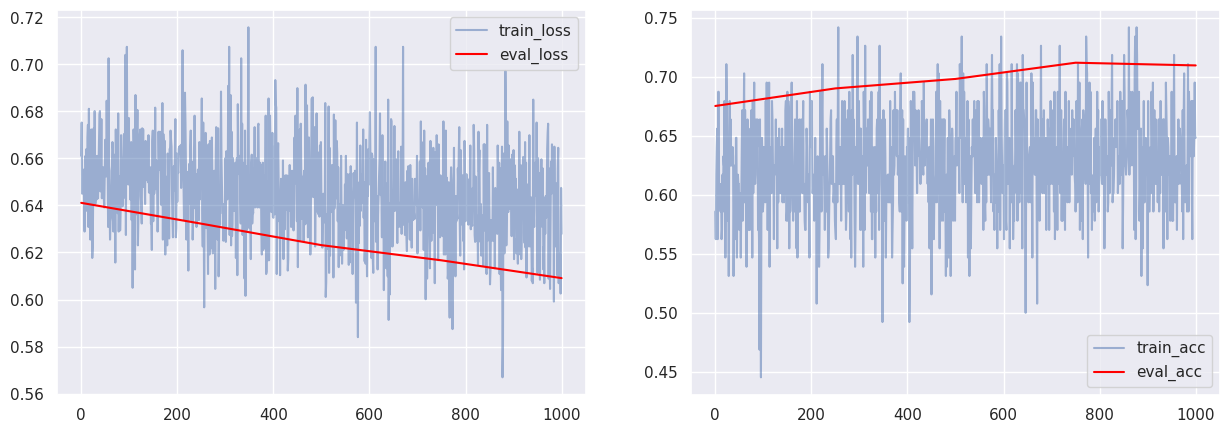

 56%|█████▌    | 218/391 [00:22<00:17,  9.74it/s]

CPU times: user 1min 45s, sys: 8.1 s, total: 1min 53s
Wall time: 1min 45s


In [47]:
%%time
training_loop_fn(pt_model, optimizer, 1000, 250, train_loader, valid_loader)

In [48]:
val_loss, val_accuracy = evaluate(pt_model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val acc: {val_accuracy}')

val loss: 0.6090972620412844
val acc: 0.7098624110221863


## LP-FT

In [64]:
chkpt = torch.load('head.pt')
chkpt.keys()

/tmp/ipykernel_138/3647206314.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpt = torch.load('head.pt')


odict_keys(['weight'])

In [65]:
chkpt

OrderedDict([('weight',
              tensor([[ 0.0385, -0.0139, -0.0185,  ..., -0.0333, -0.0018, -0.0035],
                      [-0.0052, -0.0203,  0.0244,  ...,  0.0006,  0.0498, -0.0263]],
                     device='cuda:0'))])

In [66]:
model = Model(tokenizer, num_classes).to(device)
model.model.score.load_state_dict(chkpt)
optimizer = AdamW(model.parameters(), lr=2e-6)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


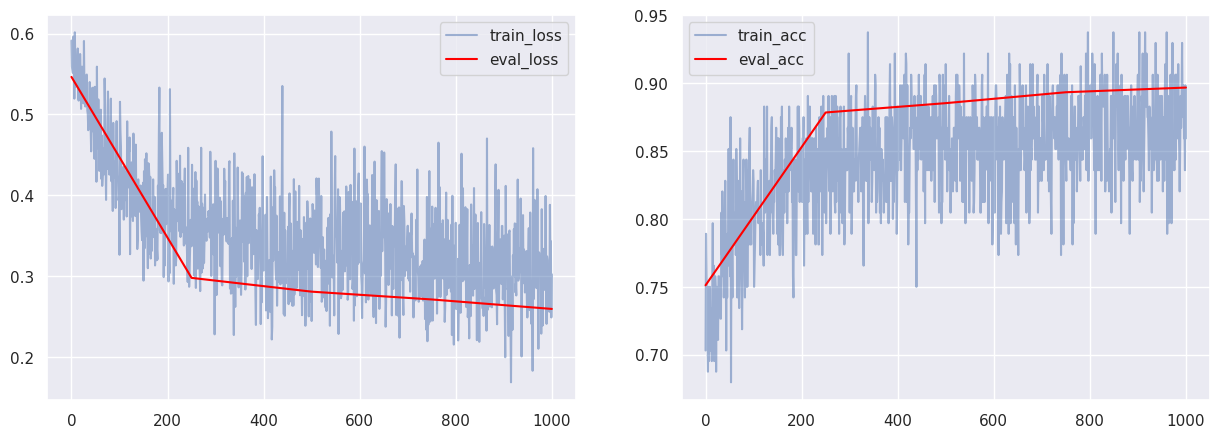

 56%|█████▌    | 218/391 [00:24<00:19,  8.96it/s]

CPU times: user 1min 47s, sys: 8.18 s, total: 1min 55s
Wall time: 1min 47s


In [67]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [68]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val accuracy: {val_acc}')

val loss: 0.2594554096186927
val accuracy: 0.896789014339447


### Testing the model

In [69]:
@torch.no_grad()
def predict(text, target=0):
    tokenized = tokenizer(text, return_tensors='pt')
    for k, v in tokenized.items():
        tokenized[k] = v.to(device)

    logits = model(tokenized['input_ids'], tokenized['attention_mask'], return_dict=False)
    probs = torch.nn.functional.softmax(logits, dim=-1)

    predicted_class_id = int(torch.argmax(logits, dim=-1))
    print(f"text: {text}")
    print(f"target: {target}, pred: {predicted_class_id}")
    print("probs:", probs.cpu().numpy())

In [70]:
predict("this movie is amaizing", 1)

text: this movie is amaizing
target: 1, pred: 0
probs: [[0.5559135 0.4440865]]


In [71]:
for i in range(10):
    text = valid_dataset[i]["sentence"]
    label = valid_dataset[i]["label"]
    predict(text, label)
    print()

text: it 's a charming and often affecting journey . 
target: 1, pred: 1
probs: [[0.0016148 0.9983852]]

text: unflinchingly bleak and desperate 
target: 0, pred: 0
probs: [[0.86730903 0.132691  ]]

text: allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . 
target: 1, pred: 1
probs: [[0.03345763 0.9665424 ]]

text: the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . 
target: 1, pred: 1
probs: [[0.01325974 0.9867403 ]]

text: it 's slow -- very , very slow . 
target: 0, pred: 0
probs: [[0.9761352  0.02386485]]

text: although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . 
target: 1, pred: 1
probs: [[0.01109042 0.98890954]]

text: a sometimes tedious film . 
target: 0, pred: 0
probs: [[0.95846707 0.04153292]]

text: or doing last year 's taxes with your ex-wife . 
target: 0, pred: 0
probs: [[0.84420794 0.15579207]